In [1]:
import csv
import sys
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 8
# tf.config.run_functions_eagerly(True)

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Reshape((1, 21 * 2)),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.LSTM(10),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 42)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 10)             2120      
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 20)                220       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                2

In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
24/35 [===================>..........] - ETA: 0s - loss: 2.0427 - accuracy: 0.3695  
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
35/35 [==============================] - 4s 22ms/step - loss: 2.0222 - accuracy: 0.3759 - val_loss: 1.9417 - val_accuracy: 0.3874
Epoch 2/1000
25/35 [====================>.........] - ETA: 0s - loss: 1.8543 - accuracy: 0.3844
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 1.8246 - accuracy: 0.3813 - val_loss: 1.6711 - val_accuracy: 0.3874
Epoch 3/1000
24/35 [===================>..........] - ETA: 0s - loss: 1.6761 - accuracy: 0.3887
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
35/35 [==============================] - 0s 4ms/step - loss: 1.6717 - accuracy: 0.3834 - val_loss: 1.6135 - val_accuracy: 0.3874
Epoch 4/1000
24/35 [===================>..........] - ETA: 0s - loss: 1.6394 - accuracy: 0.377

In [12]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

12/12 [==============================] - 0s 2ms/step - loss: 0.9803 - accuracy: 0.6698


In [13]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [14]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 1s 636ms/step
[7.9265817e-08 3.5823416e-02 9.8069221e-02 4.9953558e-02 7.6988703e-01
 3.6015082e-02 1.0251581e-02 4.5000409e-08]
4


# Confusion matrix

46/46 [==============================] - 0s 1ms/step


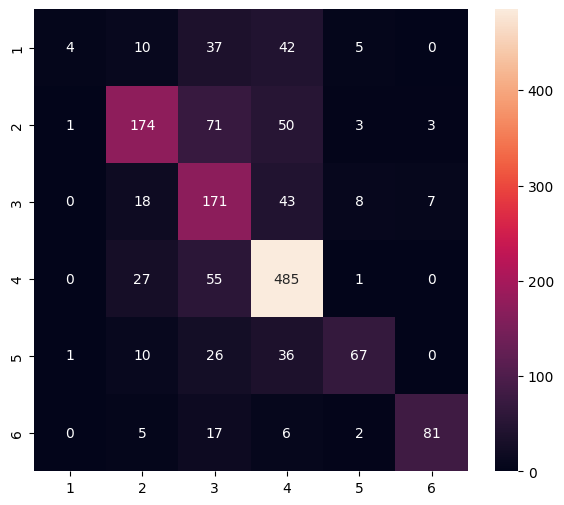

Classification Report
              precision    recall  f1-score   support

           1       0.67      0.04      0.08        98
           2       0.71      0.58      0.64       302
           3       0.45      0.69      0.55       247
           4       0.73      0.85      0.79       568
           5       0.78      0.48      0.59       140
           6       0.89      0.73      0.80       111

    accuracy                           0.67      1466
   macro avg       0.71      0.56      0.57      1466
weighted avg       0.69      0.67      0.65      1466



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [16]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [17]:
# Transform model (quantization)
# tf.config.run_functions_eagerly(False)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\91999\AppData\Local\Temp\tmpr_4evcb0\assets


INFO:tensorflow:Assets written to: C:\Users\91999\AppData\Local\Temp\tmpr_4evcb0\assets


31544

# Inference test

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 1 ms


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.9265675e-08 3.5823394e-02 9.8069273e-02 4.9953513e-02 7.6988709e-01
 3.6015060e-02 1.0251538e-02 4.5000327e-08]
4
